# Predicting NBA players' salaries
* Motivation and outline
* Data collection
* Variables
    * Salary
    * Independent Variable
* Setup Imports and Variables
* Explore the data
  *  Target feature: Salary
     * Reduce dimension by looking at correlation with salary and PCA:
  *  Input features
* Prediction
* Summary of findings

## Motivation and outline:

Are NBA palyers' salaries comparable to his market value?  Are any NBA players paid equal to the market for their services? More interestingly, what factors explain how salaries are set in the NBA?

In this notebook, I seek to answer these questions.
* Part 1 will discuss the factors that explain factors in NBA 
* Part 2 will analyze the results of that model and present the expected salaries of NBA players using 2017-18 season statistics to explain their 2018-19 salaries.
* Part 3 will will present the results of this analysis and predict the expected salaries of players for the 2019-20 season. (To be done some time in the near future)


## Data collection:

To answer the NBA Salary question,I collected salary and performance data from  https://www.basketball-reference.com <br> using BeautifulSoup module. 
* See player_dict for a list of player urls 
* See get_data.py and player_url.py for web scrapping details

Since I use data that spans two seasons, I restricted the set to players who played in both the 2017-18 and 2018-19 seasons. Also, I restricted players who earned at least $100k during the 2017-18 season as too low salaries are outliers.

Players signed contracts in different years.  The value of the contract only reflects the value at the time they signed the contract.I adjusted all contracts by adjusting the contracts proportional to the difference in the current salary cap and the salary cap of the first year the contract is effective.  

**Regulations (e.g., the salary cap, max contracts, the super max, minimum salaries, the rookie wage scale, etc.) affect the wage setting structure in the NBA.  I need to reconduct analysis taking all these factors into account.**

## Variables

### Salary:

Salary is the dependent variable. As stated above, I adjusted the salary data accounting for the increasing salary cap. **I will also apply take away the effect of various regulations in future analysis.**

### Independent variables: 

I chose the following player variables that could be correlated with the salary. I will list questions I want to explore and answer them in the analysis in later parts. No team factor needs to be added as the NBA salary cap and luxury tax system has already forced all teams to pay on the same scale. 

*    **Years in the League**

The number of years a player has played in the NBA accounts for how salaries change as players progress in their careers.  It makes sense to believe the longer a player plays in the NBA the higher the salary is? 

*    **Minutes per Game**

Players who play the most in the court should be compensated best? Usually, those who play the longest should be the best performers and hence earn highest salary?

*    **Points per 36 Minutes**

This measures the scoring ability of a player. A higher scoring ability should mean high salary?

*    **Usage rate**

This is an estimate of the percentage of team plays used by a player while he was on the floor. This is another measurement of the scoring ability of a player. Including both points per 36 minutes and usage rate would lead to the problem of multicollineairty. I will select the one with higher correlation with salary.

*    **NBA All star**

NBA All stars are effectively the best performing player in the league selected by the coaches. It makes sense that they should earn more than the other players?

We also need to include the boxscores. Rather than including steals, blocks, assits, rebounds etc separately. I opt for some overall metrics. Below are 4 I chose on the offensive and defensive end. I probably just need one pair from them , will make selection based on correlation.

*    **Offensive Win Shares**

A metric that estimates the number of wins a player produces for his team offensively.**


*    **Defensive Win Shares**

A metric that estimates the number of wins a player produces for his team defensively.**


*    **Obpm**

Offensive box plus/minus, it takes offensive box score stats from an individual and team level and tries estimate player performance relative to NBA average.

*    **Dbpm-- Defensive box plus/minus, same as above , but for defensive performance.**

In [2]:
from get_data import data
import pickle

dataframe=data()

dataframe=dataframe[dataframe['Salary']>=100000]
dataframe=dataframe.reset_index()
dataframe=dataframe.drop(['index'],axis=1)

#save the dataframe as a pickle object

with open ('player_dataframe', 'wb') as fw:
    pickle.dump(dataframe, fw)

## Setup Imports and Variables

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf
import pickle
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Set the global default size of matplotlib figures
plt.rc('figure', figsize=(10, 5))

# Size of matplotlib figures that contain subplots
fizsize_with_subplots = (10, 10)

# Size of matplotlib histogram bins
bin_size = 10

## Explore the data

Read the data:

In [4]:
with open ('player_dataframe', 'rb') as fw:
    df=pickle.load(fw)
    
df.head()

,Player_name,Years in League,Minutes per Game,Points per 36 minutes,NBA ALL STAR,Usage Rate,Offensive Win Share,Defensive Win Share,Obpm,Dbpm,Salary
0,Alex Abrines,2.0,15.5,13.9,0.0,15.9,1.2,0.9,-0.3,-2.2,5.885381e+06
1,Quincy Acy,6.0,14.7,14.3,0.0,16.8,0.5,0.5,-1.8,-1.2,1.757429e+06
2,Steven Adams,5.0,29.9,13.6,0.0,16.2,3.3,3.1,-0.7,1.2,2.310144e+07
3,Arron Afflalo,11.0,25.9,11.7,0.0,14.4,1.2,0.2,-1.4,-2.1,1.542021e+06
4,Cole Aldrich,8.0,8.6,7.1,0.0,9.4,0.6,0.7,-2.0,2.6,7.504503e+06


In [5]:
df.tail()

,Player_name,Years in League,Minutes per Game,Points per 36 minutes,NBA ALL STAR,Usage Rate,Offensive Win Share,Defensive Win Share,Obpm,Dbpm,Salary
294,Delon Wright,3.0,16.5,12.1,0.0,16.6,0.5,0.6,-0.1,1.2,1.691289e+06
295,Nick Young,11.0,25.9,18.3,0.0,19.5,3.0,0.2,2.7,-3.4,5.337449e+06
296,Thaddeus Young,11.0,30.2,13.1,0.0,16.4,2.0,2.7,0.0,1.4,1.521085e+07
297,Cody Zeller,5.0,27.8,13.3,0.0,15.5,3.4,2.2,-0.2,2.3,1.293681e+07
298,Tyle Zeller,6.0,10.3,12.2,0.0,16.5,0.5,0.6,-3.3,0.8,1.757429e+06


View the data types of each column:


In [6]:
df.dtypes

Player_name               object
Years in League          float64
Minutes per Game         float64
Points per 36 minutes    float64
NBA ALL STAR             float64
Usage Rate               float64
Offensive Win Share      float64
Defensive Win Share      float64
Obpm                     float64
Dbpm                     float64
Salary                   float64
dtype: object

Check if there is missing value

In [7]:
df.isnull().sum().sort_values(ascending=False).head(20)

#There is no missing value at all

Salary                   0
Dbpm                     0
Obpm                     0
Defensive Win Share      0
Offensive Win Share      0
Usage Rate               0
NBA ALL STAR             0
Points per 36 minutes    0
Minutes per Game         0
Years in League          0
Player_name              0
dtype: int64

Get some basic information on the DataFrame:

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 11 columns):
Player_name              299 non-null object
Years in League          299 non-null float64
Minutes per Game         299 non-null float64
Points per 36 minutes    299 non-null float64
NBA ALL STAR             299 non-null float64
Usage Rate               299 non-null float64
Offensive Win Share      299 non-null float64
Defensive Win Share      299 non-null float64
Obpm                     299 non-null float64
Dbpm                     299 non-null float64
Salary                   299 non-null float64
dtypes: float64(10), object(1)
memory usage: 25.8+ KB


Generate various descriptive statistics on the DataFrame:

In [9]:
df.describe()

,Years in League,Minutes per Game,Points per 36 minutes,NBA ALL STAR,Usage Rate,Offensive Win Share,Defensive Win Share,Obpm,Dbpm,Salary
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,2.990000e+02
mean,7.454849,23.754515,15.282609,0.193980,19.384281,2.017391,1.661873,-0.293980,-0.021405,9.597678e+06
std,3.821583,7.898242,4.917333,0.396076,5.500353,2.335235,1.098268,2.621932,1.868085,8.209165e+06
min,2.000000,3.400000,2.100000,0.000000,8.800000,-1.400000,0.000000,-9.600000,-6.100000,1.031643e+05
25%,4.000000,17.700000,11.550000,0.000000,15.250000,0.450000,0.900000,-1.900000,-1.350000,2.544965e+06
50%,7.000000,24.500000,14.600000,0.000000,19.100000,1.300000,1.500000,-0.400000,-0.100000,6.986504e+06
75%,10.000000,30.350000,18.250000,0.000000,22.650000,2.750000,2.300000,0.700000,1.200000,1.479055e+07
max,20.000000,37.800000,32.900000,1.000000,41.700000,11.500000,6.000000,10.900000,5.600000,3.565415e+07


### Target feature: Salary

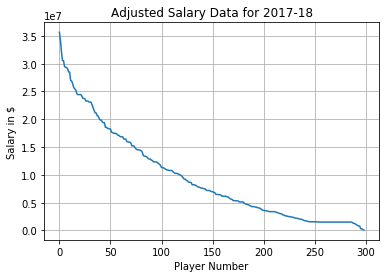

In [28]:
salary=df['Salary']
salary = sorted (salary, reverse=True)
plt.plot(range(len(salary)),salary)
plt.title('Adjusted Salary Data for 2017-18')
plt.xlabel('Player Number')
plt.ylabel('Salary in $')
plt.grid()
plt.show()

I am going to fit a linear model. Do we need to transform the salary data? 

Yes we do!!

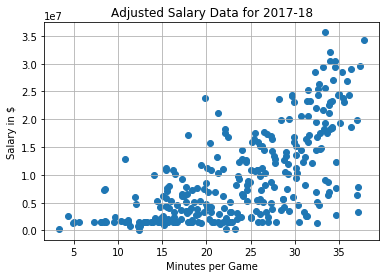

In [35]:
df.sort_values(by='Minutes per Game')
salary=df['Salary']
minutes_per_game = df['Minutes per Game']
plt.scatter(minutes_per_game,salary)
plt.title('Adjusted Salary Data for 2017-18')
plt.xlabel('Minutes per Game')
plt.ylabel('Salary in $')
plt.grid()
plt.show()

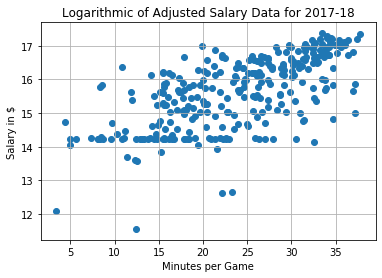

In [36]:
df.sort_values(by='Minutes per Game')
salary=np.log(df['Salary'])
minutes_per_game = df['Minutes per Game']
plt.scatter(minutes_per_game,salary)
plt.title('Logarithmic of Adjusted Salary Data for 2017-18')
plt.xlabel('Minutes per Game')
plt.ylabel('Salary in $')
plt.grid()
plt.show()


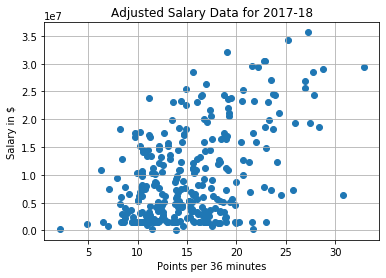

In [37]:
df.sort_values(by='Points per 36 minutes')
salary=df['Salary']
Points_per_36_minutes = df['Points per 36 minutes']
plt.scatter(Points_per_36_minutes,salary)
plt.title('Adjusted Salary Data for 2017-18')
plt.xlabel('Points per 36 minutes')
plt.ylabel('Salary in $')
plt.grid()
plt.show()

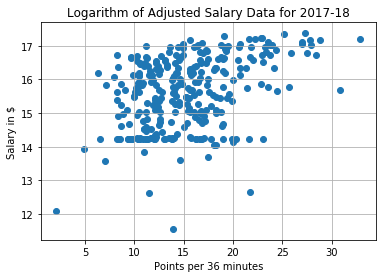

In [39]:
df.sort_values(by='Points per 36 minutes')
salary=np.log(df['Salary'])
Points_per_36_minutes = df['Points per 36 minutes']
plt.scatter(Points_per_36_minutes,salary)
plt.title('Logarithm of Adjusted Salary Data for 2017-18')
plt.xlabel('Points per 36 minutes')
plt.ylabel('Salary in $')
plt.grid()
plt.show()

The above plots shows log salary have a more linear relationship with the independent variables than salary itself. We can check if all the OLS constraints (normaility, uncorrelated error terms, same variance etc) by analysing the diagnostic plots.

### Reduce dimension by looking at correlation with salary and PCA: 

A few variables selected are correlated with each other (by definition of varaibles), so I will look at their individual correlation with target feature salary and just select one from the group of  correlated varaibles.

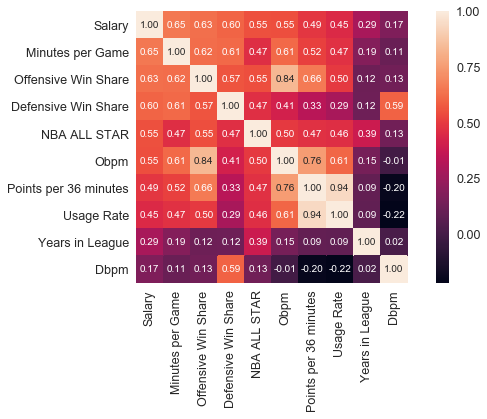

In [15]:
#drop player name
df=df.drop(['Player_name'],axis=1)
corr=df.corr()
k = 11 #number of variables for heatmap
cols = corr.nlargest(k, 'Salary')['Salary'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

From the correlelation plot, we can see the top three most correlated factors with Salary is Minutes per Game, Offensive Win Share and Defensive Win Share.

There is a high correlation between points per 36 minutes and usage rate (0.94) since players need to use possessions in order to score, which means that including both variable would introuce high collinearity and we actually just need one. As points per 36 minutes have higher correlation with salary, I decide just to include it.

Also, there is high correlation between Offensive Win Share and Obpm and also Defensive Win Share and Dbpm, and win shares have higher correlation with salaries so i decide just to use winshares.

In [16]:
#drop duplicated features

df=df.drop(['Usage Rate','Obpm','Dbpm'],axis=1)

Although the input is not of very high dimension, we could still do pca to reduce dimensions and better visualise input data.

In [17]:
#find the first two principal components

features = ['Years in League', 'Minutes per Game',
       'Points per 36 minutes', 'Offensive Win Share',
       'Defensive Win Share', 'NBA ALL STAR']
# Separating out the features
x = df.loc[:, features].values
# Separating out the target
y = df.loc[:,'Salary'].values
# Standardizing the features
x = StandardScaler().fit_transform(x)


pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, df['Salary_scale']], axis = 1)

In [18]:
finalDf.head()

,principal component 1,principal component 2,Salary_scale
0,4.782562,-0.491504,high
1,5.031614,0.931426,high
2,2.976269,1.097117,high
3,3.870449,-0.337504,high
4,3.141671,-0.071448,high


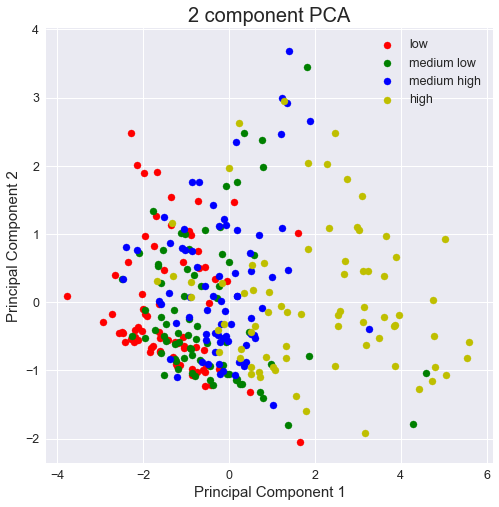

In [21]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['low','medium low','medium high','high']
colors = ['r', 'g', 'b','y']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Salary_scale'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

The PCA is not very informative ,players in different salary groups are not very well separated. So we need to dig into individual features to see how they affect salary. And I decided not to use PCA to reduce dimensions.

### Input features: 

*    Years in the League
*    Minutes per Game
*    Points per 36 Minutes
*    Offensive Win Shares -- it is a formula applied to the raw data
*    Defensive Win Shares -- it is a formula applied to the raw data
*    NBA All star 


#### Let's have a closer look at the input features individually

Years in the League

In [22]:
df['Years in League'].unique()

array([ 9., 15., 12.,  8., 11., 10.,  6.,  5., 13., 14.,  7., 17.,  4.,
       18., 20.,  3.,  2., 16.])

It ranges from 0 to 20 so it can treated as an ordinal feature.

Let's check the median salary with respect to years in the league. 

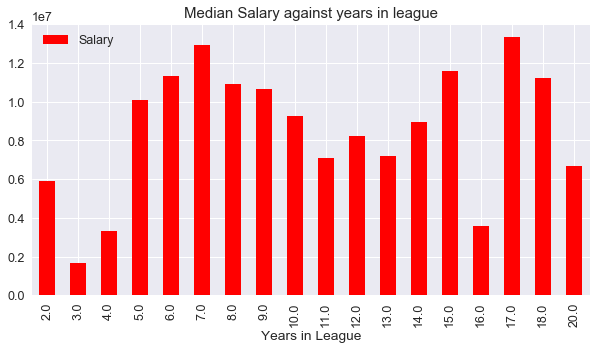

In [23]:
new_df= df.pivot_table(index='Years in League', values='Salary', aggfunc=np.median)
new_df.plot(kind='bar', color='red')
plt.title('Median Salary against years in league')
plt.show()

The graph looks weird, median salary seems to grow with year at first to the peak at the 8th year and then drop to 13th year before growing again. Then there is a bizarre dip at the 16th year. Let us have a closer lookat problematic years and see what happened.

In [24]:

#list number of observations per age group

df.groupby('Years in League').count()

,Minutes per Game,Points per 36 minutes,NBA ALL STAR,Offensive Win Share,Defensive Win Share,Salary,Salary_scale
Years in League,,,,,,,
2.0,1,1,1,1,1,1,1
3.0,45,45,45,45,45,45,45
4.0,40,40,40,40,40,40,40
5.0,31,31,31,31,31,31,31
6.0,29,29,29,29,29,29,29
7.0,24,24,24,24,24,24,24
8.0,23,23,23,23,23,23,23
9.0,20,20,20,20,20,20,20
10.0,21,21,21,21,21,21,21



We can see we have less than 6 observations at year 2, and year 16-20, results may not be realible there, it may change quite a lot year by year.
If we focus on years in the league 15-17,we will see:

In [27]:
df[df['Years in League']==15]

,Player_name,Years in League,Minutes per Game,Points per 36 minutes,NBA ALL STAR,Usage Rate,Offensive Win Share,Defensive Win Share,Obpm,Dbpm,Salary
12,Carmelo Anthony,15.0,34.3,23.5,1.0,29.1,3.2,1.5,1.5,-2.2,2.697895e+07
119,Udonis Haslem,15.0,8.1,8.6,0.0,12.8,0.0,0.2,-4.7,1.5,1.512601e+06
140,Lebron James,15.0,37.8,25.2,1.0,30.0,9.8,3.0,6.8,1.6,3.421818e+07
157,Kyle Krover,15.0,26.2,13.9,1.0,15.2,2.3,1.3,0.8,-1.0,7.196099e+06
220,Zaza Pachulia,15.0,18.1,12.1,0.0,15.3,2.3,2.5,-0.3,3.0,3.575022e+06
280,Dwyane Wade,15.0,29.9,22.0,1.0,29.6,0.9,2.5,0.4,0.6,1.598562e+07


For 15 years in the league, we can see Carmelo Anthony, Lebron James, Dwyane Wade are multiple time nba all stars, they are super super stars earning salary of order 10^7 dollars even though they are old, while average old players
like Udonis Haselm(I do not even know this guy), Kyle Krover and Zaza Pachulia earn only order 10^6 dollars salaries.

In [23]:
df[df['Years in League']==16]

,Player_name,Years in League,Minutes per Game,Points per 36 minutes,NBA ALL STAR,Offensive Win Share,Defensive Win Share,Salary
123,Nene,16.0,17.9,18.3,0.0,2.5,1.6,3.575022e+06


We only have one observation here for Nene who is a forward in the rocket team, good at defense, bad at offensive, just an average player. Data shows he earns salary of order 10^6.

In [24]:
df[df['Years in League']==17]

,Player_name,Years in League,Minutes per Game,Points per 36 minutes,NBA ALL STAR,Offensive Win Share,Defensive Win Share,Salary
53,Tyson Chandler,17.0,27.6,11.0,1.0,2.7,1.3,1.336418e+07
98,Paul Gasol,17.0,25.4,17.5,1.0,3.3,3.1,1.644823e+07
146,Joe Johnson,17.0,23.6,14.0,1.0,1.7,2.1,9.771274e+06
222,Tony Parker,17.0,25.2,14.5,1.0,1.4,1.7,1.588603e+07
236,Zach Randolph,17.0,24.5,20.7,1.0,0.8,2.4,1.265248e+07


Tyson Chadler, Paul Gasol, Tony Parkerm Zach Randolph all once were superb all stars, 15 years into their career, they all earn salary of order 10^7 dollars.

And also notice Lebron James and Camelo Anthony who are still very good players earn three times more than Tony Parker, Tyson Chandler who are no longer very good players.

#### In conclusion (for the years in the league):

The number of years a player has played in the NBA accounts for how salaries change as players progress in their careers. The longer a player plays in general, the longer the salary. This is true only up to seven years. Because the salary is more correlated with performance. Players improve until they hit their prime.  After that, their performance will decline.

The above is only true for an average player, if you are someone like leborn or tony parker, who have earned titles of nba all star players multiple times, you will still earn high salaries when you are 15 years into your career. This is an attribute to your past performance more or less. However, the salary you earn will also depend on your current ability with Lebron earning threee times as more as Tony Parker because his current much superior performance.

Minutes per Game

/Users/qha/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/qha/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/qha/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


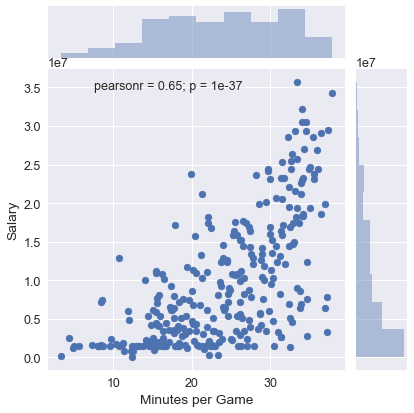

In [43]:
sns.jointplot(x=df['Minutes per Game'], y=df['Salary'])
plt.show()

There is a clear linear increasing trend with a few points diverting from the general line. Let us look at a few of them.

In [46]:
#Points above the line
print ('Points above the line')
print (df[(df['Minutes per Game']>10) & (df['Minutes per Game']<15) & (df['Salary']>10**7)]['Player_name'].values)
print (df[(df['Minutes per Game']>15) & (df['Minutes per Game']<20) & (df['Salary']>2*10**7)]['Player_name'].values)
print (df[(df['Minutes per Game']>20) & (df['Minutes per Game']<25) & (df['Salary']>2*10**7)]['Player_name'].values)


#Points below the line

print ('Points below the line')
print (df[(df['Minutes per Game']>30) & (df['Minutes per Game']<35) & (df['Salary']<0.5*10**7)]['Player_name'].values)
print (df[(df['Minutes per Game']>35) & (df['Salary']<10**7)]['Player_name'].values)

Points above the line
['AI Jefferson' 'Miles Plumlee']
['Chandler Parsons']
['Enes Kanter']
Points below the line
['Gary Harris' 'Kristaps Porzingis' 'Josh Richardson' 'Derrick Rose'
 'Marcus Smart' 'Myles Turner' 'T J Warren' 'Justise Winslow']
['Zach LaVine' 'Karl-Anthony Towns' 'Andrew Wiggs']


Points above the line are those who earn higher than their peers when playing the same number of minutes.
These people appear to be playing for bad teams but are invaluable player (they are not all rounded but are very important for special team formations). For example, AI jefferson was playing for indian pacer and he is really good at defence but not so good at offence, making him an important member of defence formation.
Chandler was playing for Memphis, another shitty team and has an important role as a small forward.

Points below the line are those who earn lower salaries than their peers when playing the same number of minutes. They seem to be there for various reasons, such as a returning super star who had severe injury or an unstable player who had a bad season. Derrick Rose was once the youngest MVP but got injured and did not play for several seasons. When he returned, his worth was quite low. But coaches were happy to give him play time to regain his former glory. Karl Anthony Towns seemed not played well that season, but he is of very high standard. Andrew Wiggs also got an injury some time earlier. Marcus Smart is a strange guy, he always try to play smart but sometimes end up humiliating himself. He was given a lot of time on court probably because he performed well the previous season. The salary is low reflects his bad performance this season. He could be good or bad in any game. The other players I am not so familiar with.

Points per 36 Minutes

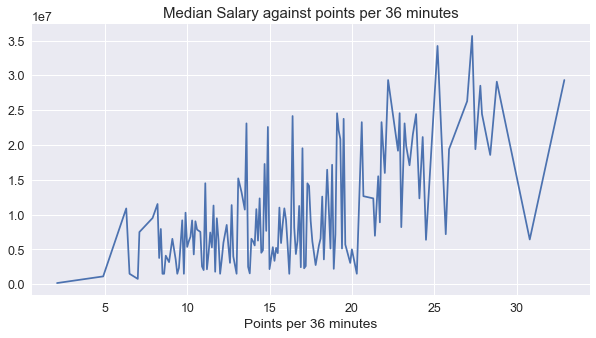

In [26]:
new_df=df.groupby(['Points per 36 minutes'], as_index=True).median()
new_df['Salary'].plot()
plt.title('Median Salary against points per 36 minutes')
plt.show()

In general there seems to be an overall increasing trend with a few dips. There is a clear jump at 20. 
It seems we can fit two different functions for salary against points per 36 minutes for the <20 and the bigger than 20 region.If we split data by points per 36 minutes>20 or <20 and look at correlation with salary, we only at 0.34 and 0.36 (see below). Overall , the correlation between points per 36 minutes and salary is 0.49, which sounds okay. This shows that although overall points per 36 minutes seem to be correlated with salary, it is actually not so important.

In [48]:
new_df=df[df['Points per 36 minutes']<20]
new_df=new_df.groupby(['Points per 36 minutes'],as_index=False).median()
new_df[['Points per 36 minutes', 'Salary']].corr()

,Points per 36 minutes,Salary
Points per 36 minutes,1.000000,0.349405
Salary,0.349405,1.000000


In [49]:
new_df=df[df['Points per 36 minutes']>20]
new_df=new_df.groupby(['Points per 36 minutes'],as_index=False).median()
new_df[['Points per 36 minutes', 'Salary']].corr()

,Points per 36 minutes,Salary
Points per 36 minutes,1.000000,0.366251
Salary,0.366251,1.000000


NBA ALL STAR

Since NBA ALL STAR only takes on two values 0 or 1.
We can do boxplots to see how it is correlated with salary.

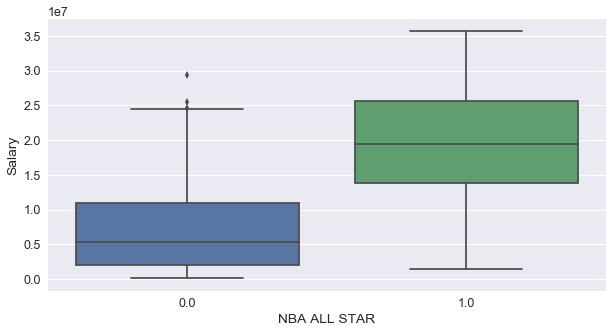

In [17]:
sns.boxplot(x=df['NBA ALL STAR'],y=df['Salary'])
plt.show()

Clearly all stars in general earn more.

We can further look at low/medium/medium high/high salaries, and show the proportion of players in each salary category for nba all stars and none nba all stars

Salary quantiles are: [103164.0, 2544965.0, 6986504.0, 14790553.0, 35654150.0]


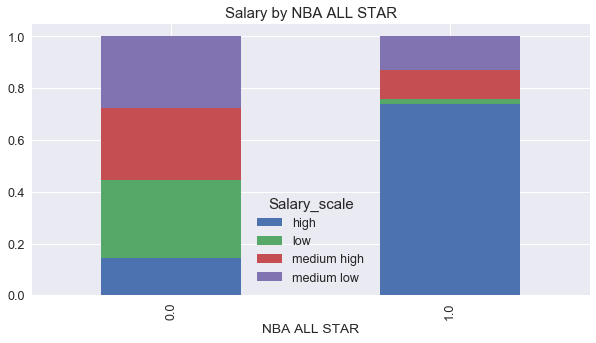

In [18]:
#plotting
nba_all_star_xt = pd.crosstab(df['NBA ALL STAR'], df['Salary_scale'])
nba_all_star_xt_pct = nba_all_star_xt.div(nba_all_star_xt.sum(1).astype(float), axis=0)
nba_all_star_xt_pct.plot(kind='bar', stacked=True, title='Salary by NBA ALL STAR')
plt.show()

While there seems to be an equal proportion of high/low/medium high/medium low pay earners among non nba all stars, almost all nba all stars are high pay earners.

Let's look at relationship between salary and years in league for the nba all star and not all star groups

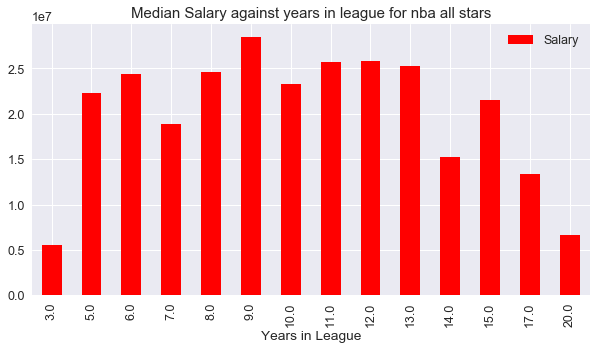

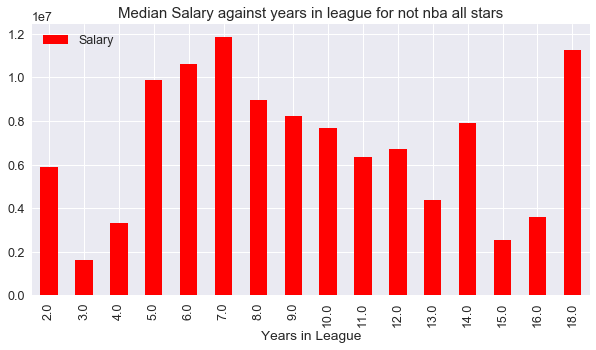

In [19]:
newer_df=df[df['NBA ALL STAR']==1]
newest_df=df[df['NBA ALL STAR']==0]

new_df= newer_df.pivot_table(index='Years in League', values='Salary', aggfunc=np.median)
new_df.plot(kind='bar', color='red')
plt.title('Median Salary against years in league for nba all stars')

new_df= newest_df.pivot_table(index='Years in League', values='Salary', aggfunc=np.median)
new_df.plot(kind='bar', color='red')
plt.title('Median Salary against years in league for not nba all stars')
plt.show()

Both of the two graphs show an increasing trend up to year 7 and then decereases with nba non all stars' salaries decrease much faster.

The irregularity at 14 and 18 in the second graph are due to two untitled good playes John Livingston and Jamal Crawford who have the nba all star abilities but were never awarded title.

So the conclusion we made for the years in League analysis we made previously makes sense.

Offensive and Defensive Win Share

/Users/qha/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/qha/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/qha/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/qha/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed

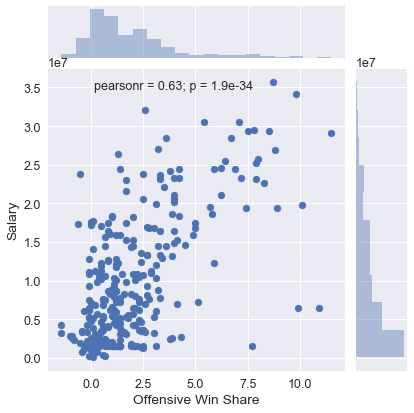

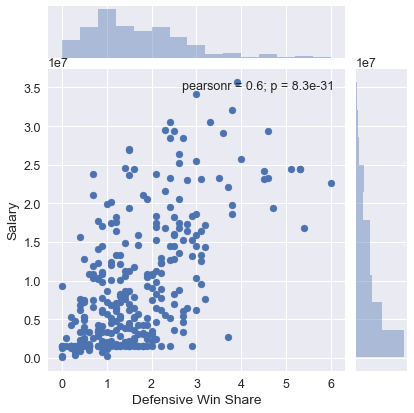

In [20]:
sns.jointplot(x=df['Offensive Win Share'], y=df['Salary'])
sns.jointplot(x=df['Defensive Win Share'], y=df['Salary'])
plt.show()

The graph shows very strong positive linear relationship.The higher the offensive/defensive win share, the higher the pay in general. However,the data is not evenly spread.  Majority observations lie at the corner. They may skew the result. To build accurate model, it may be wise to select typical players in the corner region so that we have similar number of observations in each region.

## Prediction

I will create a linear model using all input features to try to predict salary. 

To account for the aging effect, not only do I include the number of years a player has played in the NBA as a variable but I also include the squared term.  The squared term allows us to model the aging effect. 

In [47]:
df.columns=['Player_name','Years_in_League','Minutes_Per_Game','Points_per_36_Minutes','NBA_ALL_STAR','Usage_Rate','Offensive_Win_Share','Defensive_Win_Share','Obpm','Dbpm','Salary']
df['Years_in_League_Squared']=df['Years_in_League']**2

In [48]:
results = smf.ols("Salary ~ Years_in_League+Minutes_Per_Game+Points_per_36_Minutes+NBA_ALL_STAR+Offensive_Win_Share+Defensive_Win_Share+Years_in_League_Squared", data=df).fit() 
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.611
Method:                 Least Squares   F-statistic:                     67.99
Date:                Fri, 11 Jan 2019   Prob (F-statistic):           1.42e-57
Time:                        21:14:32   Log-Likelihood:                -5039.2
No. Observations:                 299   AIC:                         1.009e+04
Df Residuals:                     291   BIC:                         1.012e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept               -1

The almost zero p values show that the variables we chose are all essential in explaining salary (except points per 36 minutes)

My model is able to explain 62% of the total variance in the training set. The unexplained variance might be due to rookie salary or other regulation factors that I have not taken into account.

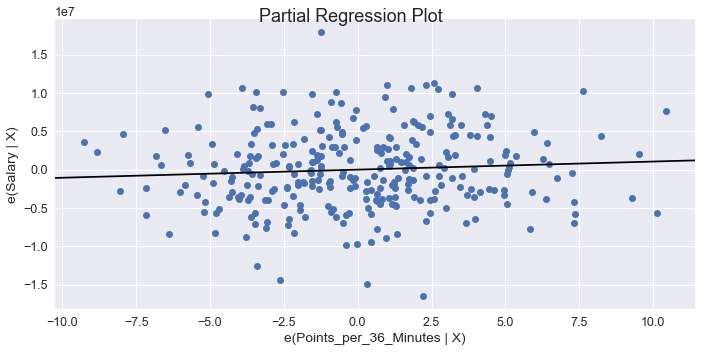

In [49]:
import statsmodels.api as sm
sm.graphics.plot_partregress_grid(results, ['Points_per_36_Minutes']);

This partial regression plot also shows that it is hard to justify a linear relationship between salary and points per 36 minutes. They seem sort of independent.

## Summary of finding

In this notebook, my aim is to identify the variables that are important to explain nba players' salaries and build models to predict salaries. I scraped data online, clean, visualise data and use it for prediction.

The most important variables in explaining nba players' salaries are:
Years_in_League,Minutes_Per_Game,NBA_ALL_STAR,Offensive_Win_Share,Defensive_Win_Share
with Points_per_36_minutes having some signficance but not as important as others.

For years in league, salary is quadratic in it. Players salaries are closely linked with their performance. Their performance on average continue to improve until the peak (which is around 7th in the league).Then the performance drops (at different rate for nba all stars and nba non all stars).

For the other variables, salary has largely a linear relationship with them. Among those, minutes per game, offensive win share and defensive win share seem to be the most significant factors as they bear the highest correlation with salary.

A few points to note about these varaibles are:

There are a few outliers with high salary and low minutes per game or low salary and high minutes per game. I explore the phenomenon and find out the interesting players.

The salary scale for nba all stars and non all stars are very different with almost all nba all stars being high salary earners.


Most players have low defensive win share, low offensive win share and low salary, meaning the observations lie heavily in the corner of salary against win share plots. The predictive power using these variables are not very trustworthy.

Although most varaibles we found are important in determing salary, overall, the training R^2 is only 0.6, not very powerful. Suggesting we need to incorporate other important factors into the model.

## References:

1. https://en.wikipedia.org/wiki/NBA_salary_cap
2. https://prosportsanalytics.com/2017/05/25/predicting-nba-salaries-part-1/